<a href="https://colab.research.google.com/github/probml/bandits/blob/main/bandits/scripts/subspace_bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deeep Bayesian Contextual Bandits

by Dmitri Saberi and Sal Spina, CS 230, Fall 2022. This repository (and this notebook) are a fork of those of Murphy et. al, at https://github.com/probml/bandits.


## Installation

In [ ]:
# !git clone --depth 1 https://github.com/probml/bandits

In [ ]:
!pip install --upgrade jax jaxlib # CPU-only
!pip3 install fire
!pip3 install ml-collections
!pip3 install git+https://github.com/deepmind/optax.git
!pip3 install flax
!pip3 install --upgrade git+https://github.com/google/flax.git
#!pip3 install -qqq git+git://github.com/deepmind/optax.git
#!pip3 install -qqq --upgrade git+https://github.com/google/flax.git
!pip3 install --upgrade git+https://github.com/google/flax.git
!pip3 install --upgrade tensorflow-probability
!pip3 install git+https://github.com/blackjax-devs/blackjax.git
!pip3 install git+https://github.com/deepmind/distrax.git
!pip3 install blackjax

## Test the installatation

In [ ]:
%%bash
cd /Users/dmitrisaberi/Documents/GitHub/bandits
python bandits test

## Setup 

In [ ]:
%cd /content/bandits/bandits/experiments

In [1]:
import os
os.chdir("..")
import matplotlib.pyplot as plt
import jax
import ml_collections
import seaborn as sns

import pandas as pd

import glob
from datetime import datetime

import scripts.movielens_exp as movielens_run
import scripts.mnist_exp as mnist_run
import scripts.tabular_exp as tabular_run
import scripts.tabular_subspace_exp as tabular_sub_run

print(jax.device_count())
timestamp = datetime.timestamp(datetime.now())

1


In [2]:
def get_config(results_filename):
  """Get the default hyperparameter configuration."""
  config = ml_collections.ConfigDict()
  config.filepath = results_filename
  config.ntrials = 2 # was 10 in paper
  return config

In [3]:
def plot_figure(data, x, y, filename, figsize=(24, 9), log_scale=False):   
    sns.set(font_scale=1.5)
    plt.style.use("seaborn-poster")

    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    g = sns.barplot(x=x, y=y, hue="Method", data=data, errwidth=2, ax=ax, palette=colors)
    if log_scale:
        g.set_yscale("log")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.savefig(f"./figures/{filename}.png")
    plt.show()

def read_data(dataset_name):
    *_, filename = sorted(glob.glob(f"./results/{dataset_name}_results*.csv"))
    df = pd.read_csv(filename)
    if dataset_name=="mnist":
        linear_df = df[(df["Method"]=="Lin-KF") | (df["Method"]=="Lin")].copy()
        linear_df["Model"] = "MLP2"
        df = df.append(linear_df)
        linear_df["Model"] = "LeNet5"
        df = df.append(linear_df)

    by = ["Rank"] if dataset_name=="tabular" else ["Rank", "AltRank"]

    data_up = df.sort_values(by=by).copy()
    data_down = df.sort_values(by=by).copy()

    data_up["Reward"] = data_up["Reward"] + data_up["Std"]
    data_down["Reward"] = data_down["Reward"] - data_down["Std"]
    data = pd.concat([data_up, data_down])
    return data

def plot_subspace_figure(df, filename=None):
    df = df.reset_index().drop(columns=["index"])
    plt.style.use("seaborn-darkgrid")
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(x="Subspace Dim", y="Reward", hue="Method", marker="o", data=df)
    lines, labels = ax.get_legend_handles_labels()
    for line, method in zip(lines, labels):
        data = df[df["Method"]==method]
        color = line.get_c()
        y_lower_bound =  data["Reward"] -  data["Std"]
        y_upper_bound = data["Reward"] + data["Std"]
        ax.fill_between(data["Subspace Dim"],  y_lower_bound, y_upper_bound, color=color, alpha=0.3)

    ax.set_ylabel("Reward", fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16) 
    plt.setp(ax.get_yticklabels(), fontsize=16) 
    ax.set_xlabel("Subspace Dimension(d)", fontsize=16)
    dataset = df.iloc[0]["Dataset"]
    ax.set_title(f"{dataset.title()} - Subspace Dim vs. Reward", fontsize=18)
    legend = ax.legend(loc="lower right", prop={'size': 16},frameon=1)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_alpha(0.6)
    
    file_path = "./figures/"
    file_path = file_path + f"{dataset}_sub_reward.png" if filename is None else file_path + f"{filename}.png"
    plt.savefig(file_path)

# Run tabular experiments (not using this!)

In [4]:
%pwd
%cd /content/bandits/bandits
tabular_filename = f"./results/tabular_results_{timestamp}.csv"
config = get_config(tabular_filename)
tabular_run.main(config)
dataset_name = "tabular"
tabular_df = read_data(dataset_name)
tabular_rows = ['EKF-Sub-SVD', 'EKF-Sub-RND', 'EKF-Sub-Diag-SVD', 'EKF-Sub-Diag-RND',
                'EKF-Orig-Full',  'EKF-Orig-Diag', 'NL-Lim', 'NL-Unlim', 'Lin', 'Lim2', 'NeuralTS']
tabular_df = tabular_df[tabular_df['Method'].isin(tabular_rows)]
x, y = "Dataset", "Reward"
filename = f"{dataset_name}_{y.lower()}"
plot_figure(tabular_df, x, y, filename)
x, y = "Dataset", "Time"
filename = f"{dataset_name}_{y.lower()}"
plot_figure(tabular_df[tabular_df["Method"] != "NeuralTS"], x, y, filename, log_scale=True)

[Errno 2] No such file or directory: '/content/bandits/bandits'
/Users/dmitrisaberi/Documents/GitHub/bandits/bandits/scripts


FileNotFoundError: [Errno 2] No such file or directory: './bandit-data/bandit-statlog.pkl'

# Run movielens experiments

In [4]:
movielens_filename = f"./results/movielens_results_{timestamp}.csv"
config = get_config(movielens_filename)
movielens_run.main(config)

Bandit : Linear
Expected Reward : 1108.50 ± 10.50
	Time : 6.873195171356201:0.3f
Bandit : BNN-UCB-LL
Expected Reward : 1370.00 ± 0.00
	Time : 11.123358964920044:0.3f
Bandit : BNN-TS-LL
Expected Reward : 1095.00 ± 0.00
	Time : 8.783574104309082:0.3f
Bandit : Linear KF
Expected Reward : 1108.50 ± 10.50
	Time : 4.136354923248291:0.3f
Bandit : Limited Neural Linear
Expected Reward : 891.00 ± 5.00
	Time : 7.375795841217041:0.3f
Bandit : Unlimited Neural Linear
Expected Reward : 1155.50 ± 60.50
	Time : 10.672983169555664:0.3f
Bandit : EKF Subspace SVD
Expected Reward : 2688.00 ± 0.00
	Time : 9.03955888748169:0.3f
Bandit : EKF Subspace RND


In [5]:
dataset_name = "movielens"
movielens_df = read_data(dataset_name)
movielens_rows =  ['EKF-Sub-SVD', 'EKF-Sub-RND', 'EKF-Sub-Diag-SVD', 'EKF-Sub-Diag-RND',
                   'EKF-Orig-Diag', 'NL-Lim', 'NL-Unlim', 'Lin', "BNN-TS-LL", "BNN-UCB-LL"]
movielens_df = movielens_df[movielens_df['Method'].isin(movielens_rows)]

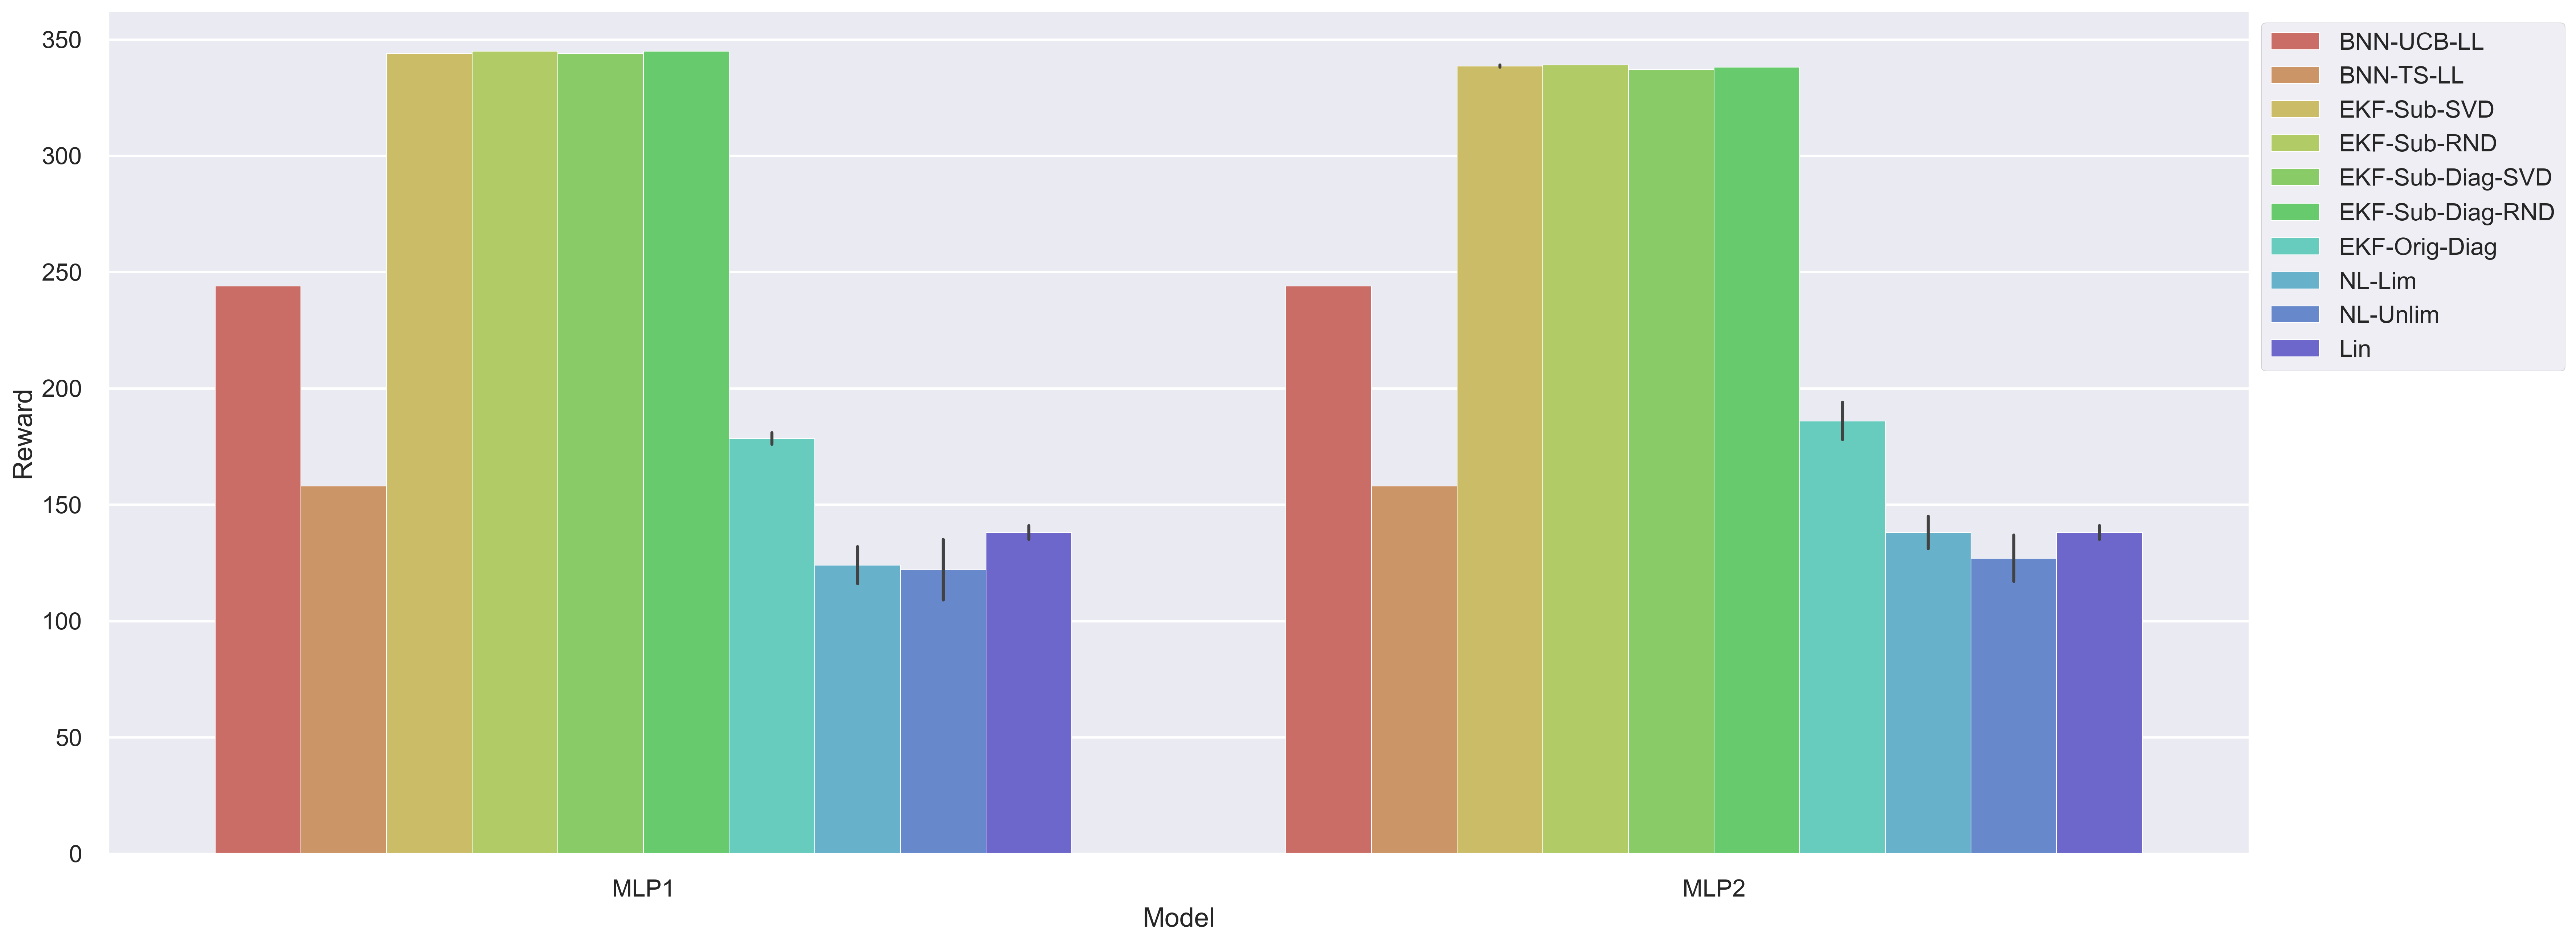

In [12]:
x, y = "Model", "Reward"
filename = f"{dataset_name}_{y.lower()}"
plot_figure(movielens_df, x, y, filename)

In [ ]:
x, y = "Model", "Time"
filename = f"{dataset_name}_{y.lower()}"
plot_figure(movielens_df, x, y, filename)

# Run MNIST experiments

In [ ]:
mnist_filename = f"./results/mnist_results_{timestamp}.csv"
config = get_config(mnist_filename)
mnist_run.main(config)

In [11]:
method_ordering = {"BNN-UCB-LL": 0,
                    "BNN-TS-LL": 1,
                    "EKF-Sub-SVD": 2,
                   "EKF-Sub-RND": 3,
                   "EKF-Sub-Diag-SVD": 4,
                   "EKF-Sub-Diag-RND": 5,
                   "EKF-Orig-Full": 6,
                   "EKF-Orig-Diag": 7,
                   "NL-Lim": 8,
                   "NL-Unlim": 9,
                   "Lin": 10,
                   "Lin-KF": 11,
                   "Lin-Wide": 12,
                   "Lim2": 13,
                   "NeuralTS": 14}
                   
colors = {k : sns.color_palette("hls", n_colors=15)[v]
          if k!="Lin-KF" else  sns.color_palette("tab20")[8]
          for k,v in method_ordering.items()}

In [ ]:
dataset_name = "mnist"
# For possible methods, run mnist_df.Method.unique()
mnist_rows = ['EKF-Sub-SVD', 'EKF-Sub-RND', 'EKF-Sub-Diag-SVD', 'EKF-Sub-Diag-RND', 'EKF-Orig-Diag', 'NL-Lim', 'NL-Unlim', 'Lin']

In [ ]:
mnist_df = read_data(dataset_name)
mnist_df = mnist_df[mnist_df['Method'].isin(mnist_rows)]

In [ ]:
x, y = "Model", "Reward"
filename = f"{dataset_name}_{y.lower()}"
plot_figure(mnist_df, x, y, filename)

In [ ]:
x, y = "Model", "Time"
filename = f"{dataset_name}_{y.lower()}"
plot_figure(mnist_df, x, y, filename, log_scale=True)

# Run tabular subspace experiment

In [ ]:
tabular_sub_filename = f"./results/tabular_subspace_results_{timestamp}.csv"
config = get_config(tabular_sub_filename)
tabular_sub_run.main(config)

In [ ]:
*_, filename = sorted(glob.glob(f"./results/tabular_subspace_results*.csv"))
tabular_sub_df = pd.read_csv(filename)

In [ ]:
dataset_name = "shuttle"
shuttle = tabular_sub_df[tabular_sub_df["Dataset"]==dataset_name]
plot_subspace_figure(shuttle)

In [ ]:
dataset_name = "adult"
adult = tabular_sub_df[tabular_sub_df["Dataset"]==dataset_name]
plot_subspace_figure(adult)

In [ ]:
from jax import vmap
from jax.random import split
from jax.lax import scan

import flax.linen as nn

In [ ]:
dataset_name = "covertype"
covertype = tabular_sub_df[tabular_sub_df["Dataset"]==dataset_name]
plot_subspace_figure(covertype)

In [ ]:
from training_utils import Net
import jax.numpy as jnp

In [ ]:
model = Net(10)
key = jax.random.PRNGKey(42)

In [ ]:
params = model.init(key, jnp.ones(10))["params"]

In [ ]:
params

In [ ]:
A = jnp.array([[1,2], [3,4]])

In [ ]:
jnp.ravel(A)